In [1]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import matplotlib.pyplot as plt
import seaborn as sb 

In [2]:
class LinearRegression:
    """
    Linear Regression class for predicting a target variable based on one or more predictor variables. 
    The input predictors and targets are assumed to be torch tensors.

    Parameters:
    - n_predictors (int): The number of predictor variables.

    Attributes:
    - params (torch.Tensor): Model parameters including the intercept and coefficients for predictor variables.
    
    """
    def __init__(self, n_predictors):
        self.params = torch.cat((torch.zeros(1), torch.ones(n_predictors)))
        
    def update_parameters(self, X, y, learning_rate = 0.001, l2_penalty = .01):
        X = torch.cat((torch.ones(len(X), 1), X), axis = 1)
        grad = -2 * X.T @ (y - X @ self.params.T) / X.size()[0] + 2 * l2_penalty * self.params
        self.params -= learning_rate * grad
        
    def fit(self, X, y, num_iter = 1000, learning_rate = 0.001, l2_penalty = .1, normal_equations = True):
        if normal_equations:
            X = torch.cat((torch.ones(len(X),1), X), axis = 1)
            self.params = torch.linalg.inv(X.T @ X + l2_penalty * torch.eye(X.size()[1])) @ X.T @ y
            return
        else:
            for _ in range(num_iter):
                self.update_parameters(X, y, learning_rate)
                        
    def predict(self, X):
        X = torch.cat((torch.ones(len(X),1), X), axis = 1)
        y_pred = X @ self.params
        return y_pred

In [3]:
class PCA:
    """
    Principal Component Analysis (PCA) class for dimensionality reduction.

    This class provides methods to perform PCA, project data onto principal components, and invert projected data.

    Attributes:
    - mean (torch.Tensor or None): The mean of the input data used for PCA.
    - eigenvalues (torch.Tensor or None): Eigenvalues of the covariance matrix.
    - eigenvectors (torch.Tensor or None): Eigenvectors corresponding to the eigenvalues.
    
    """
    def __init__(self):
        self.mean = None
        self.eigenvalues = None
        self.eigenvectors = None
        
    def fit(self, X):
        mu = torch.mean(X)
        self.mean = mu
        
        X_demeaned = X - mu
        
        eigs, V = torch.linalg.eigh(X_demeaned.T @ X_demeaned)
        self.eigenvectors = torch.fliplr(V)
        self.eigenvalues = torch.flip(eigs, [-1])
    
    def project(self, X, k, l = 0):
        
        assert k < len(self.eigenvectors) and (type(k) == int)
        assert (l > -1) and (l < k) and (type(k) == int)
        
        X_demeaned = X - self.mean
        X_proj = X_demeaned @ self.eigenvectors[:, l : k]
        
        return X_proj
    
    def project_indices(self, X, indices = None):
                
        X_demeaned = X - self.mean
        X_proj = X_demeaned @ self.eigenvectors[:, indices]
        
        return X_proj
    
    def inverse_project(self, X, k):
        
        assert k < len(self.eigenvectors)
        
        X_proj = X @ self.eigenvectors[:, :k].T + self.mean
        return X_proj

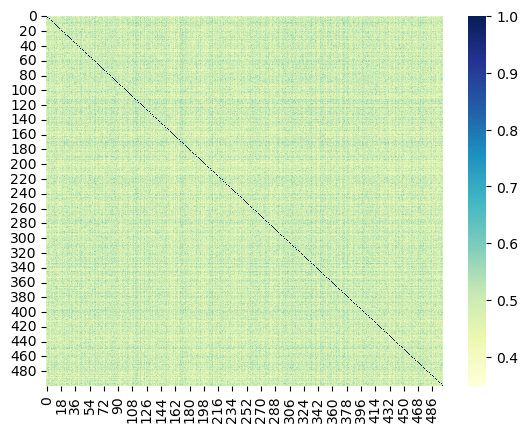

In [4]:
n_features = 500
df = n_features
m = 50000

torch.random.manual_seed(42)

# Generate a covariance matrix C 
G = torch.randn(n_features, df)
M = torch.ones((n_features, df))
C = (G + M).T @ (G + M)
C = C / np.sqrt(n_features * df)

# Generate a multivariate normal sample
mvn = torch.distributions.MultivariateNormal(torch.zeros(n_features), covariance_matrix = C)
X = mvn.sample((m,))

# Get a noisy linear combination of correlated normals
coeffs = torch.rand(n_features)
bias = torch.rand(1)
noise = torch.randn(m)
y = X @ coeffs + bias + noise

sb.heatmap(torch.corrcoef(X.T), cmap = "YlGnBu")
plt.show()

In [5]:
p = .2
X_train_tensor = X[:int(m * (1-p))]
y_train_tensor = y[:int(m * (1-p))]
X_test_tensor = X[int(m * (1-p)):]
y_test_tensor = y[int(m * (1-p)):]

# Verify the shapes of the tensors
print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

X_train_tensor shape: torch.Size([40000, 500])
y_train_tensor shape: torch.Size([40000])
X_test_tensor shape: torch.Size([10000, 500])
y_test_tensor shape: torch.Size([10000])


In [6]:
# Create an instance of the LinearRegression class
linreg = LinearRegression(n_features)

# Fit the model using all the features
linreg.fit(X_train_tensor, y_train_tensor, normal_equations = True)

# Make predictions on the test data
y_pred_tensor = linreg.predict(X_test_tensor)

# Evaluate the model's performance

# Convert predictions and actual values back to np arrays
y_pred = np.squeeze(y_pred_tensor.detach())
y_test = np.squeeze(y_test_tensor.detach())

# Calculate Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate R-squared (R2) score
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")

Mean Absolute Error: 15.03
Root Mean Squared Error: 18.76
R-squared (R2) Score: 0.99


In [7]:
# Create an instance of the PCA class
pca = PCA()

# Fit the PCA model
pca.fit(X_train_tensor)

# Number of principal components to select
k = 1

X_proj = pca.project(X_train_tensor, k)

# Create an instance of the LinearRegression class
linreg = LinearRegression(k)

# Fit the model using the k largest principal components as features
linreg.fit(X_proj, y_train_tensor, normal_equations = True)

# Make predictions on the test data
y_pred_tensor = linreg.predict(pca.project(X_test_tensor, k))

# Evaluate the model's performance

# Convert predictions and actual values back to np arrays
y_pred = np.squeeze(y_pred_tensor.detach())
y_test = np.squeeze(y_test_tensor.detach())

# Calculate Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate R-squared (R2) score
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")

Mean Absolute Error: 5.14
Root Mean Squared Error: 6.43
R-squared (R2) Score: 1.00
